# Synthetic MNIST Manifold: Comparison of Gaussian smoothing and Manifold-Adapted Smoothing
- In this notebook, we construct a 1d manifold of MNIST digit images, and compare Gaussian smoothing and manifold-adapted smoothing generations
- To construct the 1d manifold:
    - Train a VAE on MNIST, encoding into a 32 dimensional space
    - Draw a closed curve between selected points (of a single class) in the latent space
    - Decode to obtain a closed curve in image space, which constitutes the ground-truth manifold
    - The training data consists of 10 points along the curve
- Run smoothed diffusion models using both types of smoothing
    - isotropic Gaussian smoothing
    - manifold-adapted smoothing - smoothing along a translated version of the manifold, passing through the current point
- For the generated samples, report the following:
    - $L_2$ distance to manifold, relative to the $L_2$ distance to the empirical dataset (implicitly controlled by changing the smoothing parameter)
    - FID of the generated samples, relative to the $L_2$ distance to the empirical dataset (implicitly controlled by changing the smoothing parameter). The FID values are computed using the features of a trained classifier.

In [ ]:
import os  # before importing anything jax
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = "0.90"

# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['CUDA_VISIBLE_DEVICES']='0'

import jax
import jax.numpy as jnp

import numpy as np

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from IPython.display import clear_output

import pickle as pkl

from src.diffusion import VE_diffuser, log_hat_pt, empirical_eps_fn, sample_rev
from src.plotting import plot_images, add_arrows
from src.smoothing import get_smoothed_fn, get_proj_idx_interpolant, get_manifold_translated_smoothed_fn
from src.vae import create_vae
from src.classifier import Classifier, CNN
from src.fid import compute_fid

# plot formatting
import seaborn as sns
from matplotlib.lines import Line2D
sns.set_theme()  # sets a nicer global style for plots
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif'})

## load mnist data
- reshape to (32,32,1)
- use the MNIST test set of 10,000 samples for the VAE and classifier training

(60000, 32, 32, 1)


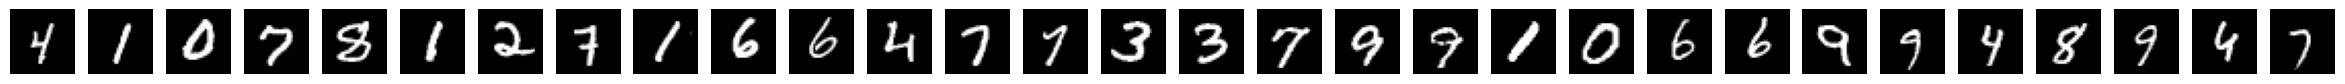

In [2]:
def pad_to_32(batch):
    """
    Pad the batch of images from (28, 28, 1) to (32, 32, 1).
    Args:
        batch: jnp array of shape (batch_size, 28, 28, 1)
    Returns:
        jnp array of shape (batch_size, 32, 32, 1)
    """
    return jnp.pad(batch, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant')

# Load MNIST data
all_images = jnp.load('data/train_images.npy')
all_images = pad_to_32(all_images)

all_images = all_images / 255.0 # Normalize pixel values to be between 0 and 1

# look at some of the images
print(all_images.shape)  # Output: (60000, 32, 32, 1)
plot_images(all_images[:30], n=30)

# define which ones to use for the VAE and classifier training
vae_images = jnp.load('data/test_images.npy')
vae_images = pad_to_32(vae_images)
vae_images = vae_images / 255.0

vae_labels = jnp.load('data/test_labels.npy')

# validation set for monitoring the classifier training
valid_images = all_images[:10_000]
valid_labels = jnp.load('data/train_labels.npy')[:10_000]

## train/load VAE

In [3]:
vae_config = {
    'model_config': {
        'dim_init': 16,
        'kernel_size': 3,
        'dim_mults': (1, 2, 2, 2),
        'num_groups': 4,
        'latent_dim': 32,
        'dropout': 0.1
    },
    'training_config': {
        'learning_rate': 1e-3,
        'batch_size': 64,
        'num_steps': 10000,
        'num_checkpoints': 5,
    }
}

rng = jax.random.PRNGKey(0)
vae, init_params = create_vae(rng, vae_config['model_config'])

# params, losses, params_lst = vae.train(rng, init_params, vae_images, vae_config['training_config'])
# plt.plot(losses)
# plt.yscale('log')

# Save params
# with open('params/vae_params.pkl', 'wb') as f:
#     pkl.dump(params, f)

# Load pretrained params
with open('params/vae_params.pkl', 'rb') as f:
    params = pkl.load(f)

E1007 16:52:10.608253 3936897 hlo_lexer.cc:443] Failed to parse int literal: 894515288310727292233


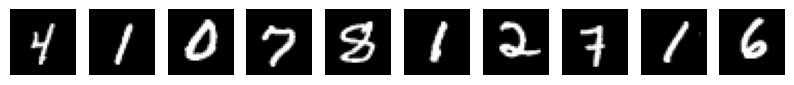

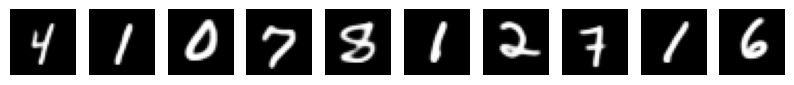

In [4]:
# check reconstructions
test_samples = all_images[:10]

reconstructions, means, log_vars = vae.apply(params, test_samples, train=False, rngs={'dropout': rng})

plot_images(test_samples)
plot_images(reconstructions)

# train/load classifier
- to use the penultimate layer for FID calculation

In [5]:
# define which data to use for the classifier training
classifier_images = vae_images
classifier_labels = vae_labels

In [6]:
# train
classifier_config = {
        'learning_rate': 1e-3,
        'batch_size': 64,
        'num_steps': 5000,
        'num_checkpoints': 5,
    }

classifier_model = CNN()
classifier_init_params = classifier_model.init(jax.random.PRNGKey(0), jnp.ones((1, 32, 32, 1)))
classifier = Classifier(classifier_model)

# classifier_params, classifier_losses, classifier_params_lst = classifier.train(
#     rng,
#     classifier_init_params, 
#     classifier_images, 
#     classifier_labels, 
#     valid_images, 
#     valid_labels, 
#     classifier_config
# )

# with open('params/classifier_params.pkl', 'wb') as f:
#     pkl.dump(classifier_params, f)

with open('params/classifier_params.pkl', 'rb') as f:
    classifier_params = pkl.load(f)

## calculating FID using the classifier
- Check that the FID values behave as expected. The FID between sets of true samples should be small, and the FID between a set of true samples and reconstructions should be larger.

In [8]:
# check that the FID scores are reasonable
reconstructions, means, log_vars = vae.apply(params, vae_images[:10_000], train=False, rngs={'dropout': rng})

# FID between two sets of true samples - should be good
fid = compute_fid(classifier_params, classifier_model, valid_images, all_images[10_000:])
print(f'FID between two sets of true samples: {fid}')

# FID between reconstructions and true images - should be worse
fid = compute_fid(classifier_params, classifier_model, reconstructions, all_images[10_000:])
print(f'FID between reconstructions and true images: {fid}')

2025-10-07 16:52:29.965694: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-07 16:52:30.435847: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 10.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-07 16:52:30.435887: W external/xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 11.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-07 16:52:30.435901: W external/xla/xla/tsl/framework/bfc_alloca

FID between two sets of true samples: 2.0048828125
FID between reconstructions and true images: 42.73291015625


## construct a manifold
- We consider a synthetic 1d image manifold defined by a closed curve $\phi : [0, 2\pi) \to \R^{\text{32} \times \text{32}}$
- We take 3 images from the dataset (of the same class)
- We draw a triangular interpolation in the latent space
- The latents are then decoded to construct a 1d manifold in pixel space, parameterised by $\alpha \in (0,1)$

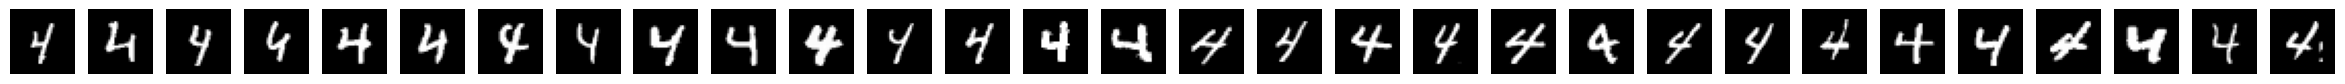

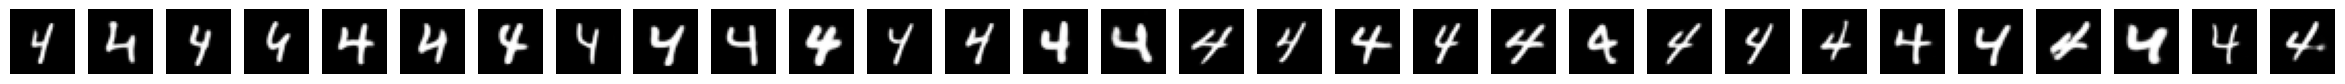

(Array(0, dtype=int32),
 Array(11, dtype=int32),
 Array(25, dtype=int32),
 Array(28, dtype=int32),
 Array(34, dtype=int32),
 Array(39, dtype=int32))

In [9]:
# select a single digit class
train_idxs = jnp.load('data/train_labels.npy')

digit = 4   # pick the digit to use for the manifold construction
idxs = jnp.where(train_idxs == digit)[0]

# look at the images and the reconstructions
plot_images(all_images[idxs], n=30)
reconstructions, means, log_vars = vae.apply(params, all_images[idxs[:30]], train=False, rngs={'dropout': rng})
plot_images(reconstructions, n=30)

filtered_train_images = all_images[idxs]
# print the first few indices for the filtered images
idxs[0], idxs[1], idxs[2], idxs[3], idxs[4], idxs[5]

In [10]:
# pick three of the same digit for the triangle corners (usually, the from the first few in the dataset, provided the resulting manifold decodes ok)

if digit == 2:
    x0 = all_images[6]
    x1 = all_images[41]
    x2 = all_images[48]

if digit == 3:
    x0 = all_images[14]
    x1 = all_images[15]
    x2 = all_images[30]

if digit == 4:
    x0 = all_images[0]
    x1 = all_images[11] #[28]
    x2 = all_images[25]

if digit == 5:
    x0 = all_images[52]
    x1 = all_images[62]
    x2 = all_images[70] #[68]

if digit == 7:
    x0 = all_images[3]
    x1 = all_images[7]
    x2 = all_images[12] #[68]

# eights (needs a bit more smoothing)
if digit == 8:
    x0 = all_images[4]
    x1 = all_images[26]
    x2 = all_images[38] #[68]

# get the latent representations of the three images
latent_0 = vae.apply(params, x0[None], train=False)[1][0]
latent_1 = vae.apply(params, x1[None], train=False)[1][0]
latent_2 = vae.apply(params, x2[None], train=False)[1][0]

x0.shape, x1.shape, x2.shape, latent_0.shape, latent_1.shape, latent_2.shape

((32, 32, 1), (32, 32, 1), (32, 32, 1), (32,), (32,), (32,))

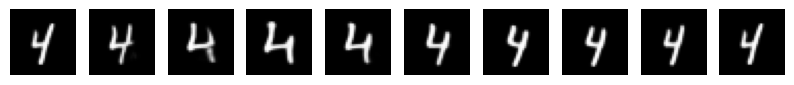

In [11]:
# construct the curve, by decoding a triangle drawn in the latent space
@jax.jit
def pixel_curve(alpha):  # alpha in [0, 1]
    # Define breakpoints
    t1 = 1/3
    t2 = 2/3

    def interp(a, b, t):
        return (1 - t) * a + t * b

    # Map alpha to triangle edges
    z = jax.lax.cond(
        alpha < t1,
        lambda a: interp(latent_0, latent_1, a / t1),
        lambda a: jax.lax.cond(
            a < t2,
            lambda a2: interp(latent_1, latent_2, (a2 - t1) / (t2 - t1)),
            lambda a2: interp(latent_2, latent_0, (a2 - t2) / (1 - t2)),
            a
        ),
        alpha
    )

    # Decode latent point
    return vae.apply(params, z[None], method=vae.decode)[0]


# look at some points along the manifold
alphas = jnp.linspace(0, 1, 10)  # More points for smoother triangle
manifold_images = jnp.array([pixel_curve(alpha) for alpha in alphas])
plot_images(manifold_images)

## generate points
- We will generate a small number of points along the curve to use as the empirical training dataset
- We also generate a large number of points to use as an approximation to the true manifold

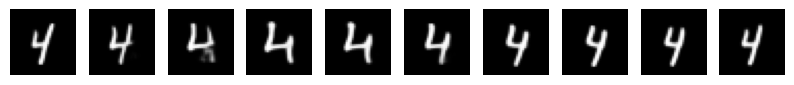

In [12]:
# approximation of the true manifold
all_alphas = jnp.linspace(0, 1, 1000, endpoint=False)  # 1000 points for smooth curve
interpolants = jnp.array([pixel_curve(alpha) for alpha in all_alphas])  # approx to the true manifold

# training dataset
num_points = 10  # Number of empirical datapoints for diffusion
train_alphas = jnp.linspace(0, 1, num_points, endpoint=False)
train_images = jnp.array([pixel_curve(alpha) for alpha in train_alphas])

# test images for FID calculation (approximation of the true manifold)
fid_alphas = jax.random.uniform(jax.random.PRNGKey(0), (1000,))  # Random alphas for FID
fid_images = jnp.array([pixel_curve(alpha) for alpha in fid_alphas])

image_shape = train_images.shape[1:]

plot_images(train_images, n=num_points)  # visualise the training images

In [13]:
# function to return the closest image
def get_closest_image(image, images):
    """Find the closest image in the dataset to the given image."""
    diffs = jnp.sqrt( jnp.sum((images - image) ** 2, axis=(1, 2, 3)) ) # norm differences
    closest_idx = jnp.argmin(diffs)
    return images[closest_idx], diffs[closest_idx], closest_idx

## Diffusion
- Now, we will run a VE diffusion model using the various different score functions

In [14]:
# first, define the VE diffusion object
ve = VE_diffuser(sigma_min=0.001, sigma_max=3.0)

### Empirical score generations
- We first run the diffusion process using the empirical score function
- This should generate only training samples

Empirical Score Generations:


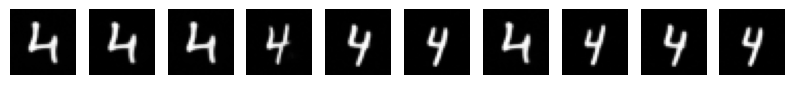

---------------------
Closest images in dataset:


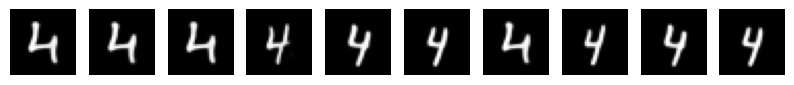

Distance to nearest training datapoint: [0.03165283 0.03085217 0.03118318 0.03163923 0.03280693 0.03278743
 0.03323146 0.03256622 0.03148864 0.03268455]
---------------------
Closest images on manifold:


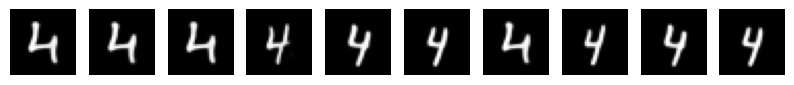

Distance to nearest point on manifold: [0.03165283 0.03085218 0.03118319 0.03163925 0.03280692 0.03278744
 0.03323146 0.03256622 0.03148862 0.03268455]


In [15]:
num_samples = 10

data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)

key = jax.random.PRNGKey(0)
xs, traj = sample_rev(ve, key, data_empirical_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

print('Empirical Score Generations:')
plot_images(xs, n=num_samples)

print('---------------------')
print('Closest images in dataset:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(xs, train_images)
plot_images(closest_images, n=num_samples)
print('Distance to nearest training datapoint:', dists)

print('---------------------')
print('Closest images on manifold:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(xs, interpolants)
plot_images(closest_images, n=num_samples)
print('Distance to nearest point on manifold:', dists)

### Smoothed diffusion with an isotropic Gaussian kernel

Generations:


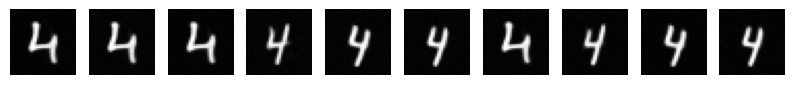

---------------------
Closest images in dataset:


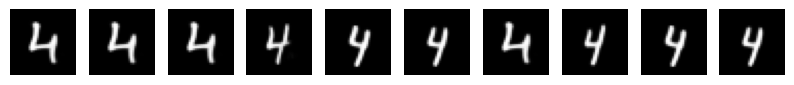

Distance to nearest training datapoint: [0.9843443  0.95373386 1.0091362  1.3521647  0.6677539  0.457903
 0.9577967  0.6945621  1.0878867  0.4603987 ]
---------------------
Closest images on manifold:


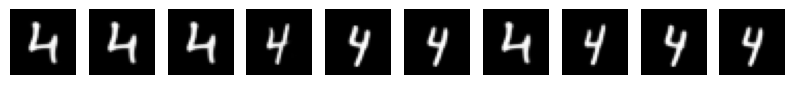

Distance to nearest point on manifold: [0.5506765  0.5422362  0.55311257 0.8629034  0.6444044  0.3622957
 0.5418877  0.555122   0.8055624  0.36486202]


In [16]:
# run smoothed diffusion
num_samples = 10 

data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)

# smooth the empirical score function
smoothing_param = 1.1
smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=50_000) #10_000) # 1.8

# run the diffusion process
key = jax.random.PRNGKey(0)
gaussian_samples, traj = sample_rev(ve, key, smoothed_emp_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

print('Generations:')
plot_images(gaussian_samples, n=num_samples)

print('---------------------')
print('Closest images in dataset:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(gaussian_samples, train_images)
plot_images(closest_images, n=num_samples)
print('Distance to nearest training datapoint:', dists)

print('---------------------')
print('Closest images on manifold:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(gaussian_samples, interpolants)
plot_images(closest_images, n=num_samples)
print('Distance to nearest point on manifold:', dists)

### Smoothed diffusion with manifold-adapted kernel
- Here, we use a manifold-adapted smoothing kernel that smooths the empirical score along a translation of the manifold through the current position

Generations:


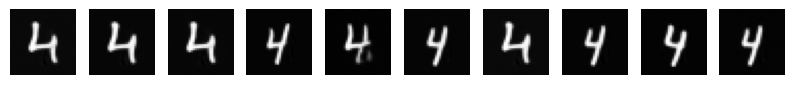

---------------------
Closest images in dataset:


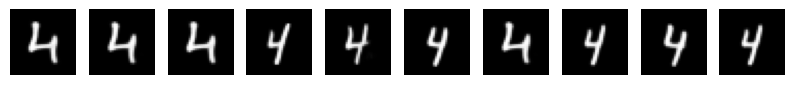

Distance to nearest training datapoint: [0.830474   0.71570086 0.61770964 1.6554748  2.557384   1.6085597
 0.22027467 1.0534183  1.2124175  1.1364155 ]
---------------------
Closest images on manifold:


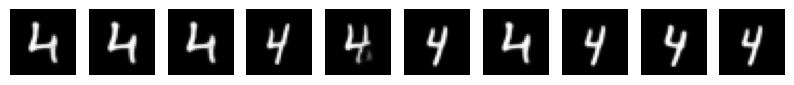

Distance to nearest point on manifold: [0.19876586 0.21494244 0.20502926 0.13737805 0.20286459 0.1395701
 0.18405132 0.14347799 0.1499258  0.13598289]


In [17]:
num_samples = 10

data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)

smoothed_emp_eps_fn = get_manifold_translated_smoothed_fn(data_empirical_eps_fn, 7.0, all_alphas, interpolants, n=1000)

key = jax.random.PRNGKey(0)
adapted_samples, traj = sample_rev(ve, key, smoothed_emp_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

print('Generations:')
plot_images(adapted_samples, n=num_samples)

print('---------------------')
print('Closest images in dataset:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(adapted_samples, train_images)
plot_images(closest_images, n=num_samples)
print('Distance to nearest training datapoint:', dists)

print('---------------------')
print('Closest images on manifold:')
closest_images, dists, closest_image_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(adapted_samples, interpolants)
plot_images(closest_images, n=num_samples)
print('Distance to nearest point on manifold:', dists)

## generate many samples, to use for generating the plots
- We now compare the different mechanisms, for increasing smoothing levels
- The smoothing levels are selected to induce comparable $L_2$ distances from the empirical dataset in the samples

### Gaussian smoothing

In [18]:
def run_gaussian_smoothing_param(smoothing_param,
                         num_samples=100,
                         batch_size=20,
                         num_steps=100,
                         n_smooth=50_000,
                         key=jax.random.PRNGKey(0)):
    
    num_batches = num_samples // batch_size

    # Define smoothed empirical eps function
    data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)
    smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=n_smooth)

    gaussian_samples = []
    dists_to_data = []
    dists_to_manifold = []
    proj_alphas = []

    # do it in batches to avoid memory issues
    for _ in range(num_batches):
        key, subkey = jax.random.split(key)
        gaussian_samples_batch, _ = sample_rev(
            ve, subkey, smoothed_emp_eps_fn, batch_size,
            image_shape=image_shape, num_steps=num_steps
        )

        gaussian_samples.append(gaussian_samples_batch)

        # Distance to data
        _, dists_data, _ = jax.vmap(get_closest_image, in_axes=(0, None))(
            gaussian_samples_batch, train_images)
        dists_to_data.append(dists_data)

        # Distance to manifold
        _, dists_manifold, closest_idxs = jax.vmap(get_closest_image, in_axes=(0, None))(
            gaussian_samples_batch, interpolants)
        dists_to_manifold.append(dists_manifold)

        proj_alphas.append(all_alphas[closest_idxs])

    gaussian_samples = jnp.concatenate(gaussian_samples, axis=0)
    dists_to_data = jnp.concatenate(dists_to_data, axis=0)
    dists_to_manifold = jnp.concatenate(dists_to_manifold, axis=0)
    proj_alphas = jnp.concatenate(proj_alphas, axis=0)

    fid = compute_fid(classifier_params, classifier_model, gaussian_samples, fid_images, batch_size=1000)

    return gaussian_samples, dists_to_data, dists_to_manifold, fid, proj_alphas

In [19]:
num_samples = 100
batch_size = 20
num_steps = 100
n_smooth = 50_000

gaussian_smoothing_params = jnp.array([0.0, 0.3, 0.6, 0.8, 0.9, 1.0, 1.05, 1.1])

all_gaussian_samples = []
all_gaussian_dists_to_data = []
all_gaussian_dists_to_manifold = []
all_gaussian_fids = []
all_gaussian_proj_alphas = []

for smoothing_param in gaussian_smoothing_params:
    print(f'Running smoothing param: {smoothing_param}')
    samples, dists_to_data, dists_to_manifold, fid, proj_alphas = run_gaussian_smoothing_param(
        smoothing_param, num_samples=num_samples, batch_size=batch_size, num_steps=num_steps, n_smooth=n_smooth)
    
    all_gaussian_samples.append(samples)
    all_gaussian_dists_to_data.append(dists_to_data)
    all_gaussian_dists_to_manifold.append(dists_to_manifold)
    all_gaussian_fids.append(fid)
    all_gaussian_proj_alphas.append(proj_alphas)

all_gaussian_samples = jnp.array(all_gaussian_samples)
all_gaussian_dists_to_data = jnp.array(all_gaussian_dists_to_data)
all_gaussian_dists_to_manifold = jnp.array(all_gaussian_dists_to_manifold)
all_gaussian_fids = jnp.array(all_gaussian_fids)
all_gaussian_proj_alphas = jnp.array(all_gaussian_proj_alphas)

Running smoothing param: 0.0
Running smoothing param: 0.30000001192092896
Running smoothing param: 0.6000000238418579
Running smoothing param: 0.800000011920929
Running smoothing param: 0.8999999761581421
Running smoothing param: 1.0
Running smoothing param: 1.0499999523162842
Running smoothing param: 1.100000023841858


We can examine to what extent the generated samples are spread along the manifold by plotting histograms of the $\alpha$ parameter of the projection onto the manifold. For small smoothing level $\sigma$, they should be concentrated on the empirical datapoint locations, while for larger $\sigma$ we want to see to what extent they have spread out to fill the gaps.

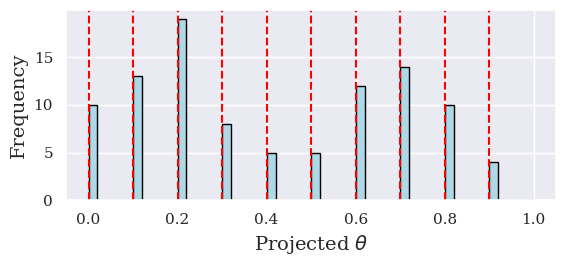

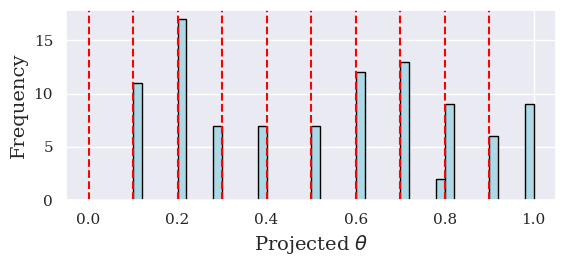

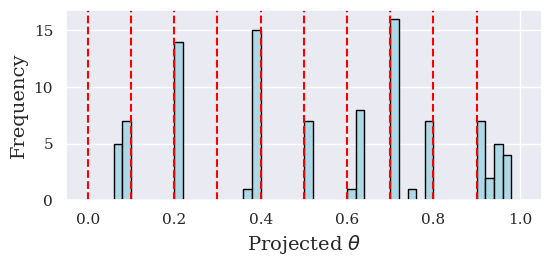

In [20]:
def plot_histogram(proj_alphas):
    plt.figure(figsize=(6,3))
    plt.hist(proj_alphas, bins=50, range=(0, 1), color='lightblue', edgecolor='black')

    # Overlay vertical lines for true theta values
    for theta in train_alphas:
        plt.axvline(theta, color='red', linestyle='--', linewidth=1.5)

    # Axis labels and formatting
    plt.xlabel('Projected $\\theta$', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()

plot_histogram(all_gaussian_proj_alphas[0])
plot_histogram(all_gaussian_proj_alphas[2])
plot_histogram(all_gaussian_proj_alphas[-1])

### manifold-adapted smoothing

In [21]:
def run_adapted_smoothing_param(smoothing_param,
                         num_samples=100,
                         batch_size=20,
                         num_steps=100,
                         n_smooth=1_000,
                         key=jax.random.PRNGKey(0)):
    
    data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, train_images, t)
    
    num_batches = num_samples // batch_size

    # Define smoothed empirical eps function
    smoothed_emp_eps_fn = get_manifold_translated_smoothed_fn(data_empirical_eps_fn, smoothing_param, all_alphas, interpolants, n=n_smooth)

    adapted_samples = []
    dists_to_data = []
    dists_to_manifold = []
    proj_alphas = []

    for _ in range(num_batches):
        key, subkey = jax.random.split(key)
        adapted_samples_batch, _ = sample_rev(
            ve, subkey, smoothed_emp_eps_fn, batch_size,
            image_shape=image_shape, num_steps=num_steps
        )

        adapted_samples.append(adapted_samples_batch)

        # Distance to data
        _, dists_data, _ = jax.vmap(get_closest_image, in_axes=(0, None))(
            adapted_samples_batch, train_images)
        dists_to_data.append(dists_data)

        # Distance to manifold
        _, dists_manifold, closest_idx = jax.vmap(get_closest_image, in_axes=(0, None))(
            adapted_samples_batch, interpolants)
        dists_to_manifold.append(dists_manifold)

        proj_alphas.append(all_alphas[closest_idx])

    adapted_samples = jnp.concatenate(adapted_samples, axis=0)
    dists_to_data = jnp.concatenate(dists_to_data, axis=0)
    dists_to_manifold = jnp.concatenate(dists_to_manifold, axis=0)
    proj_alphas = jnp.concatenate(proj_alphas, axis=0)

    fid = compute_fid(classifier_params, classifier_model, adapted_samples, fid_images, batch_size=1000)

    return adapted_samples, dists_to_data, dists_to_manifold, fid, proj_alphas

In [22]:
n_smooth = 1_000

adapted_smoothing_params = jnp.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 4.0, 7.0])

all_adapted_samples = []
all_adapted_dists_to_data = []
all_adapted_dists_to_manifold = []
all_adapted_fids = []
all_adapted_proj_alphas = []

for smoothing_param in adapted_smoothing_params:
    print(f'Running smoothing param: {smoothing_param}')
    samples, dists_to_data, dists_to_manifold, fid, proj_alphas = run_adapted_smoothing_param(
        smoothing_param, num_samples=num_samples, batch_size=batch_size, num_steps=num_steps, n_smooth=n_smooth)
    
    all_adapted_samples.append(samples)
    all_adapted_dists_to_data.append(dists_to_data)
    all_adapted_dists_to_manifold.append(dists_to_manifold)
    all_adapted_fids.append(fid)
    all_adapted_proj_alphas.append(proj_alphas)

all_adapted_samples = jnp.array(all_adapted_samples)
all_adapted_dists_to_data = jnp.array(all_adapted_dists_to_data)
all_adapted_dists_to_manifold = jnp.array(all_adapted_dists_to_manifold)
all_adapted_fids = jnp.array(all_adapted_fids)
all_adapted_proj_alphas = jnp.array(all_adapted_proj_alphas)

Running smoothing param: 0.0
Running smoothing param: 0.5
Running smoothing param: 1.0
Running smoothing param: 1.5
Running smoothing param: 2.0
Running smoothing param: 2.5
Running smoothing param: 4.0
Running smoothing param: 7.0


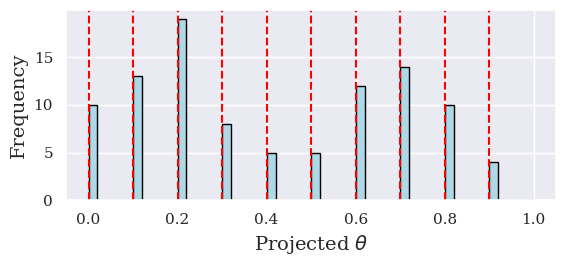

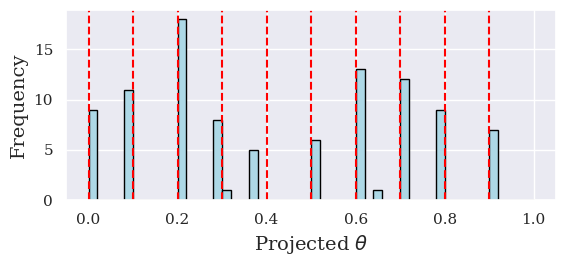

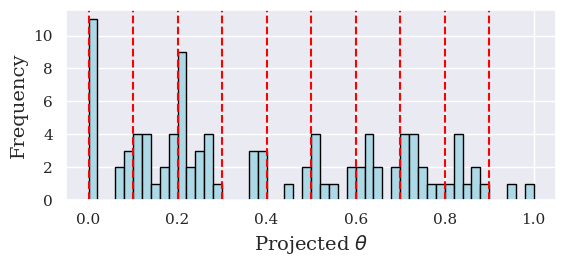

In [23]:
plot_histogram(all_adapted_proj_alphas[0])
plot_histogram(all_adapted_proj_alphas[2])
plot_histogram(all_adapted_proj_alphas[-1])

## also compare to KDE samples

In [24]:
KDE_params = jnp.array([0.0, 0.004, 0.008, 0.012, 0.016, 0.020, 0.024])

all_KDE_samples = []
all_KDE_dists_to_data = []
all_KDE_dists_to_manifold = []
all_KDE_fids = []

for KDE_param in KDE_params:
    
    key, mean_subkey, noise_subkey = jax.random.split(key, 3)
    mean_idxs = jax.random.choice(mean_subkey, num_points, shape=(num_samples,), replace=True)
    samples = train_images[mean_idxs] + KDE_param * jax.random.normal(noise_subkey, shape=(num_samples, *image_shape))

    # Distance to data
    _, dists_to_data, _ = jax.vmap(get_closest_image, in_axes=(0, None))(
        samples, train_images)

    # Distance to manifold
    _, dists_to_manifold, closest_idx = jax.vmap(get_closest_image, in_axes=(0, None))(
        samples, interpolants)

    all_KDE_samples.append(samples)
    all_KDE_dists_to_data.append(dists_to_data)
    all_KDE_dists_to_manifold.append(dists_to_manifold)

    fid = compute_fid(classifier_params, classifier_model, samples, fid_images, batch_size=1000)
    all_KDE_fids.append(fid)

all_KDE_samples = jnp.array(all_KDE_samples)
all_KDE_dists_to_data = jnp.array(all_KDE_dists_to_data)
all_KDE_dists_to_manifold = jnp.array(all_KDE_dists_to_manifold)
all_KDE_fids = jnp.array(all_KDE_fids)

## make plots
- Make the following two plots:
    - $L_2$ distance to manifold, relative to the $L_2$ distance to the empirical samples  (implicitly controlled by changing the smoothing parameter)
    - FID of the generated samples, relative to the $L_2$ distance to the empirical sample (implicitly controlled by changing the smoothing parameter)

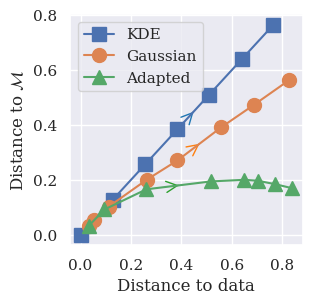

In [25]:
avg_gaussian_data_distances = jnp.mean(all_gaussian_dists_to_data, axis=1)
avg_gaussian_manifold_distances = jnp.mean(all_gaussian_dists_to_manifold, axis=1)

avg_adapted_data_distances = jnp.mean(all_adapted_dists_to_data, axis=1)
avg_adapted_manifold_distances = jnp.mean(all_adapted_dists_to_manifold, axis=1)

avg_KDE_data_distances = jnp.mean(all_KDE_dists_to_data, axis=1)
avg_KDE_manifold_distances = jnp.mean(all_KDE_dists_to_manifold, axis=1)

# Plot scatter plot with arrows
plt.figure(figsize=(3,3))

# Plot and extract line objects
line_KDE = plt.plot(avg_KDE_data_distances, avg_KDE_manifold_distances,  marker='s', ms=10, label='KDE')[0]
line_gaussian = plt.plot(avg_gaussian_data_distances, avg_gaussian_manifold_distances,  marker='o', ms=10, label='Gaussian')[0]
line_adapted = plt.plot(avg_adapted_data_distances, avg_adapted_manifold_distances,  marker='^', ms=10, label='Adapted')[0]

# Add arrows to the lines
add_arrows(line_KDE, segment_index=3, color='tab:blue')
add_arrows(line_gaussian, segment_index=4, color='tab:orange')
add_arrows(line_adapted, segment_index=2, color='tab:green')

plt.xlabel("Distance to data")
plt.ylabel("Distance to $\mathcal{M}$")
plt.grid(True)

# Add y = x reference line
min_val = min(
    avg_adapted_manifold_distances.min(),
    avg_adapted_data_distances.min(),
    avg_gaussian_manifold_distances.min(),
    avg_gaussian_data_distances.min()
)
max_val = max(
    avg_adapted_manifold_distances.max(),
    avg_adapted_data_distances.max(),
    avg_gaussian_manifold_distances.max(),
    avg_gaussian_data_distances.max()
)
# plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')
plt.legend(loc='upper left')

plt.savefig(f"figures/mnist_L2_{digit}s.pdf", bbox_inches='tight')
plt.show()

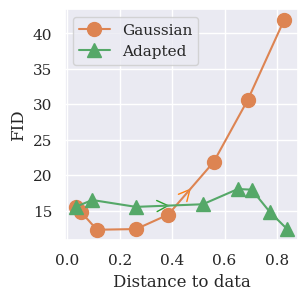

In [26]:
# Plot scatter plot with arrows
plt.figure(figsize=(3,3))

# Plot and extract line objects

pal = sns.color_palette()   # nice, colorblind-safe seaborn palette
orange, green = pal[1], pal[2]  

line_gaussian = plt.plot(avg_gaussian_data_distances, all_gaussian_fids,  marker='o', ms=10, label='Gaussian', color=orange)[0]
line_adapted = plt.plot(avg_adapted_data_distances, all_adapted_fids,  marker='^', ms=10, label='Adapted', color=green)[0]

# Add arrows to the lines
add_arrows(line_gaussian, segment_index=4, color='tab:orange')
add_arrows(line_adapted, segment_index=2, color='tab:green')

plt.xlabel("Distance to data")
plt.ylabel("FID")
plt.grid(True)

# plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')
plt.legend(loc='upper left')

plt.savefig(f"figures/mnist_fid_{digit}s.pdf", bbox_inches='tight')
plt.show()

## visualise the samples

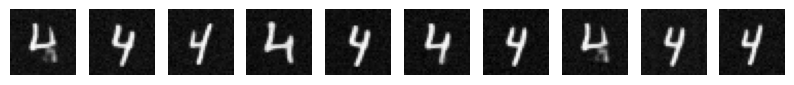

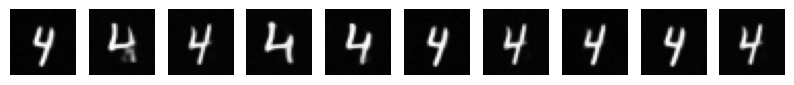

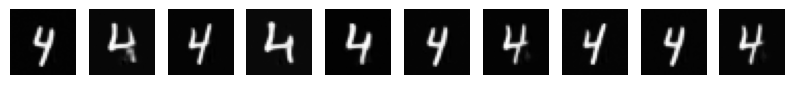

In [27]:
plot_images(all_KDE_samples[-1], n=10)
plot_images(all_gaussian_samples[-1], n=10)
plot_images(all_adapted_samples[-1], n=10)